In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys

In [2]:
sys.path.append('/home/local/WIN/msang2/mankun/Notebooks/[01]dimerEnhanceProteinDNA/')
# modules for direct calculation
import analytics as ana
import analyzeEqui as num
# stochastic simulation (Gillespie)
# from Simulations.odeSolver.reversible.singleS import labels
from Simulations.odeSolver.monomer.singleS import process_task as task_m
from Simulations.odeSolver.reversible.singleS import process_task as task_rev, labels
from Simulations.odeSolver.dimer.singleS import process_task as task_irr
from Simulations.odeSolver.main import main as numericSolver

In [3]:
def plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.55,0.00], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
):
    labelfont = {'fontsize':labelFontSize*scale}
    tickfont = {'fontsize':tickFontSize*scale}
    legend = {'fontsize':lgdFontSize*scale, 'loc':lgdLoc, 'handlelength':lgdHandleL*scale, 
              'title':lgdTitle, 'title_fontsize':lgdTtlFontSize*scale,
             'framealpha':0.0}
    if fixSize:
        fig = plt.figure(figsize=(sizeX*scale,sizeY*scale))
        ax = fig.add_subplot(111)
    else:
        ax = plt.gca()
    plt.tick_params(length=tickL*scale, width=tickW*scale)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(spineLineW*scale)  # change width
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    linsStyles = ['-', '--']
    return ax, colors, linsStyles, legend, labelfont, tickfont, 0.6022 # C0, nm^-3 -> M

In [4]:
# Generate parameters
# input units: M
# output units: nm & s
# conversion: 0.6022 nm^-3 = 1 M

def __staticParms(hasTargets = True):
    
    kaPN = lambda K: np.round(200,10)
    kbPN = lambda K: np.round(kaPN(K)/K,10)
    
    kaPS = lambda K: np.round(1000,10)
    kbPS = lambda K: np.round(kaPS(K)/K,10)
    
    kbPP = lambda K: np.round(10 / (K*C0/1e1)**(4/9), 10)
    kaPP = lambda K: np.round(K*kbPP(K), 10)
    
    V0 = 2.1e4 # nm^3
    VtoL = 1000 # nm^2

    if hasTargets:
        CN0 = 10/V0 # nm^-3
        CS0 = 2/V0
    else:
        CN0 = 12/V0 # nm^-3
        CS0 = 20/V0
    C0 = 0.6022 # 0.6022 nm^-3 = 1 M 
    
    return kaPP, kbPP, kaPN, kbPN, kaPS, kbPS, V0, VtoL, CN0, CS0, C0
    
def GenParameters(
    filename='', ifwrite=False, hasTargets = True,
    KPS=lambda KPN: 1e3*KPN, 
    CP0=[np.nan], NP0=[np.nan], 
    KPN=[np.nan], KPP=[np.nan], 
    area3Dto1D=[np.nan],
):
    headers = [
        "ID", "CN0", "CS0", "CP0", 
        "KPS", "KPN", "KPP", "gamma", 
        "kaPS", "kaPN", "kaPP", 
        "kbPS", "kbPN", "kbPP"
    ]

    # generate data
    data = []
    number = 0
    kaPP, kbPP, kaPN, kbPN, kaPS, kbPS, V0, VtoL, CN0, CS0, C0 = \
    __staticParms(hasTargets)

    # These parameters are fixed
    if np.isnan(CP0).any() & np.isnan(NP0).any():
        raise ValueError('No protein provided! Set CP0 or NP0!')
    elif not np.isnan(CP0).any():
        CP0_list = np.array(CP0)*C0 # convert M to nm^-3
    else:
        CP0_list = np.array(NP0) / V0
        
    if np.isnan(KPN).any():
        raise ValueError('No KPN provided!')
    else:
        KPN_list = np.array(KPN)/C0
        
    if np.isnan(KPP).any():
        raise ValueError('No KPP provided!')
    else:
        KPP_list = np.array(KPP)/C0
        
    if np.isnan(area3Dto1D).any():
        raise ValueError('No area3Dto1D provided!')
    else:
        area3Dto1D_list = np.array(area3Dto1D)
    
    for _CP0 in CP0_list:
        # These parameters are varied
        for _KPN in KPN_list:
            _KPS = KPS(_KPN*C0)/C0
            for _area3Dto1D in area3Dto1D_list:
                for _KPP in KPP_list:
                    entry = {
                        'ID':number,
                        "CN0":CN0,
                        "CS0":CS0,
                        "CP0":_CP0,
                        "KPN":np.round(_KPN, 10),
                        "kaPN":kaPN(_KPN),
                        "kbPN":kbPN(_KPN),
                        "KPS":np.round(_KPS, 10),
                        "kaPS":kaPS(_KPS),
                        "kbPS":kbPS(_KPS),
                        "KPP":np.round(_KPP, 10),
                        "kaPP":kaPP(_KPP),
                        "kbPP":kbPP(_KPP),
                        "gamma":VtoL/_area3Dto1D
                    }
                    data.append(entry)
                    number += 1

    if ifwrite:
        # Specify the output CSV file name
        output_file = filename
        # # Write the data to the CSV file
        import csv
        with open(output_file, mode="w", newline="") as file:
            writer = csv.DictWriter(file, fieldnames=headers)
            writer.writeheader()
            writer.writerows(data)
        print("CSV file generated successfully!")
    
    return pd.DataFrame(data, columns=headers)

## change CP0

In [5]:
parm_ana = GenParameters(
    hasTargets=True, CP0=np.logspace(-8,-5,7+3*20),
    KPN=[2e1, 2e2], KPP=[np.exp(10)], area3Dto1D=[1,10,100],
)
parm_num = GenParameters(
    hasTargets=True, CP0=np.logspace(-8,-5,7),
    KPN=[2e1, 2e2], KPP=[np.exp(10)], area3Dto1D=[1,10,100],
)

In [5]:
equi_num_rev = numericSolver(parm_df=parm_num, labels=labels, model=task_rev)

pBound_num_rev = np.zeros(parm_num.shape[0])
tauB_num_rev = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    parm = parm_num.iloc[iloc]
    pBound_num_rev[iloc] = num.calc_BoundRatio_modelB(parm, equi_num_rev.iloc[iloc])
    tauB_num_rev[iloc] = num.calc_resT_modelB(parm, equi_num_rev.iloc[iloc])

2024-08-16 16:21:11.661684
Number of cores used:  34/36
Finished parallel processing.


In [7]:
pBound = np.zeros(parm_ana.shape[0])
tauB = np.zeros(parm_ana.shape[0])
for iloc in range(parm_ana.shape[0]):
    parm = parm_ana.iloc[iloc]
    pBound[iloc] = ana.ana_bound_ratio(parm, numClusterS=1)
    tauB[iloc] = ana.ana_resTime_balance(parm, numClusterS=1)

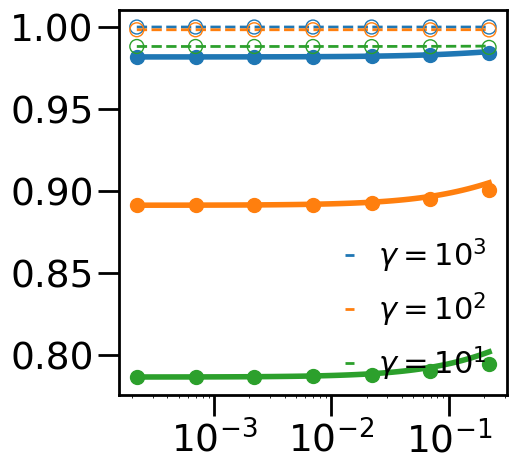

In [10]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.55,0.00], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
gamList = np.unique(parm_ana['gamma'])
kpnList = np.unique(parm_ana['KPN'])
for i, gam in enumerate(gamList[::-1]):
    for j, kpn in enumerate(kpnList):
        selected = ((parm_ana['gamma']==gam)&(parm_ana['KPN']==kpn))
        selected_num = ((parm_num['gamma']==gam)&(parm_num['KPN']==kpn))
        if j==0:
            ax.plot(
                (parm_ana['KPP']*parm_ana['CP0'])[selected],
                pBound[selected],
                ls = lineStyles[j], zorder=1,
                color = colors[i], lw=4,
            )
            ax.scatter(
                (parm_num['KPP']*parm_num['CP0'])[selected_num],
                pBound_num_rev[selected_num],
                color = colors[i], zorder=3, s=100,
            )
        elif j==1:
            ax.plot(
                (parm_ana['KPP']*parm_ana['CP0'])[selected],
                pBound[selected],
                ls = lineStyles[j], color = colors[i], 
                lw=2, zorder=2,
                label='$\\gamma=10^{%.0f}$'%(np.log10(gam)),
            )
            ax.scatter(
                (parm_num['KPP']*parm_num['CP0'])[selected_num],
                pBound_num_rev[selected_num],
                color = colors[i], zorder=4, s=100,
                marker='o', facecolor='none',
            )
            
            
ax.semilogx()
plt.legend(**legend)
plt.xticks( **tickfont)
plt.yticks(**tickfont)
plt.savefig('resT_vs_chiN_gamma_DIMER.png', transparent=True)

## Change KPP

In [48]:
parm_ana = GenParameters(
    hasTargets=True, NP0=[0.1], KPS=lambda KPN:1e3*5*2,
    KPN=[2e1, 2e2], KPP=np.logspace(0,10,10+9*3), area3Dto1D=[1,10,100],
)
parm_num = GenParameters(
    hasTargets=True, NP0=[0.2], KPS=lambda KPN:1e3*5*2,
    KPN=[2e1, 2e2], KPP=np.logspace(0,10,10), area3Dto1D=[1,10,100],
)

In [49]:
equi_num_rev = numericSolver(parm_df=parm_num, labels=labels, model=task_rev)

pBound_num_rev = np.zeros(parm_num.shape[0])
tauB_num_rev = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    parm = parm_num.iloc[iloc]
    pBound_num_rev[iloc] = num.calc_BoundRatio_modelB(parm, equi_num_rev.iloc[iloc])
    tauB_num_rev[iloc] = num.calc_resT_modelB(parm, equi_num_rev.iloc[iloc])

2024-08-16 16:45:36.293892
Number of cores used:  34/36
Finished parallel processing.


In [50]:
pBound = np.zeros(parm_ana.shape[0])
tauB = np.zeros(parm_ana.shape[0])
for iloc in range(parm_ana.shape[0]):
    parm = parm_ana.iloc[iloc]
    pBound[iloc] = ana.ana_bound_ratio(parm, numClusterS=1)
    tauB[iloc] = ana.ana_resTime_balance(parm, numClusterS=1)

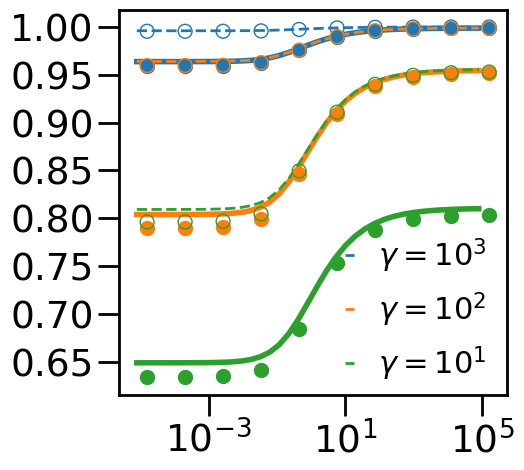

In [52]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.55,0.00], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
gamList = np.unique(parm_ana['gamma'])
kpnList = np.unique(parm_ana['KPN'])
for i, gam in enumerate(gamList[::-1]):
    for j, kpn in enumerate(kpnList):
        selected = ((parm_ana['gamma']==gam)&(parm_ana['KPN']==kpn))
        selected_num = ((parm_num['gamma']==gam)&(parm_num['KPN']==kpn))
        if j==0:
            ax.plot(
                (parm_ana['KPP']*parm_ana['CP0'])[selected],
                pBound[selected],
                ls = lineStyles[j], zorder=1,
                color = colors[i], lw=4,
            )
            ax.scatter(
                (parm_num['KPP']*parm_num['CP0'])[selected_num],
                pBound_num_rev[selected_num],
                color = colors[i], zorder=3, s=100,
            )
        elif j==1:
            ax.plot(
                (parm_ana['KPP']*parm_ana['CP0'])[selected],
                pBound[selected],
                ls = lineStyles[j], color = colors[i], 
                lw=2, zorder=2,
                label='$\\gamma=10^{%.0f}$'%(np.log10(gam)),
            )
            ax.scatter(
                (parm_num['KPP']*parm_num['CP0'])[selected_num],
                pBound_num_rev[selected_num],
                color = colors[i], zorder=4, s=100,
                marker='o', facecolor='none',
            )
            
            
ax.semilogx()
plt.legend(**legend)
plt.xticks([1e-3, 1e1, 1e5], ['$10^{-3}$', '$10^{1}$', '$10^{5}$'], **tickfont)
plt.yticks(**tickfont)
plt.savefig('resT_vs_chiN_gamma_DIMER.png', transparent=True)

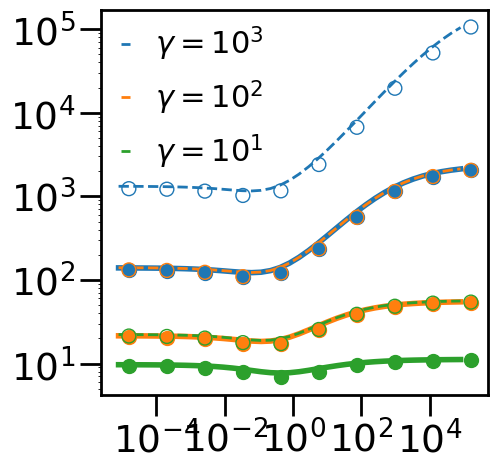

In [58]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.02,0.55], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
gamList = np.unique(parm_ana['gamma'])
kpnList = np.unique(parm_ana['KPN'])
for i, gam in enumerate(gamList[::-1]):
    for j, kpn in enumerate(kpnList):
        selected = ((parm_ana['gamma']==gam)&(parm_ana['KPN']==kpn))
        selected_num = ((parm_num['gamma']==gam)&(parm_num['KPN']==kpn))
        if j==0:
            ax.plot(
                (parm_ana['KPP']*parm_ana['CP0'])[selected],
                tauB[selected],
                ls = lineStyles[j], zorder=1,
                color = colors[i], lw=4,
            )
            ax.scatter(
                (parm_num['KPP']*parm_num['CP0'])[selected_num],
                tauB_num_rev[selected_num],
                color = colors[i], zorder=3, s=100,
            )
        elif j==1:
            ax.plot(
                (parm_ana['KPP']*parm_ana['CP0'])[selected],
                tauB[selected],
                ls = lineStyles[j], color = colors[i], 
                lw=2, zorder=2,
                label='$\\gamma=10^{%.0f}$'%(np.log10(gam)),
            )
            ax.scatter(
                (parm_num['KPP']*parm_num['CP0'])[selected_num],
                tauB_num_rev[selected_num],
                color = colors[i], zorder=4, s=100,
                marker='o', facecolor='none',
            )
            
            
ax.loglog()
plt.legend(**legend)
plt.xticks( **tickfont)
plt.yticks(**tickfont)
plt.savefig('resT_vs_chiN_gamma_DIMER.png', transparent=True)